# Выявление данных для дальшейшей перепроверки.

In [3]:
import xlrd
import pandas as pd
import re
train_xls = xlrd.open_workbook('./data_kat/Real/train_311.xlsx')
test_xls = xlrd.open_workbook('./data_kat/Real/test_90.xlsx')

def rename(name, train=None, test=None, grp=None, vr=None):
    '''rename files depending on the names of the tables'''
    if type(name) != list:
        name = [name]
    new_name = []
    for n in name:
        num = int(re.sub('[^0-9]', '', n))
        if n[:2] == 'rr':
            if num >= 90:
                new_name.append('train_' + train.sheet_names()[num - 90])
            else: new_name.append('test_' + test.sheet_names()[num])
        elif n[:2] == 'sg':
            new_name.append('grp_{}_row'.format(num))
        else:
            new_name.append('vr_{}_row'.format(num))
    return new_name

def save_img(name, save=False, pred=True):
    d = dict(np.load('./npz/'+name))
    plt.figure(figsize=(15, 10))
    plt.scatter(np.log10(d['time']), np.log10(d['derivative']), s=20)
    plt.axhline(np.log10(d['target']), ls='--', c='g', lw=1, alpha=1, label='real value')
    if pred:
        plt.axhline(np.log10(np.mean(results[name]['pred'])), ls='--', c='b', lw=1, alpha=1, label='prediction')
    plt.title('{}'.format(rename(name, train_xls, test_xls)[0]))
    plt.legend()
    if save:
        plt.savefig('./log_imgs/'+rename(name, train_xls, test_xls)[0]+'.png', dpi=100)

['train_Приобка_100', 'train_Приобка_237', 'grp_10_row', 'vr_43_row']

In [4]:
import os
import sys
sys.path.insert(0, os.path.join('..'))
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

import radial as rd
from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C
from radial.batchflow.models.tf import ResNet18
from radial.core import RadialBatch, concatenate_points, draw_results

plt.style.use('ggplot')
%matplotlib inline

In [5]:
N_SAMPLES = 50

In [4]:
model_config = {
    'inputs': dict(points=dict(shape=(2, N_SAMPLES)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [8, 16, 32],
    'initial_block/filters': 4,
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [5]:
norm_ppl = (Pipeline()
            .load(fmt='npz')
            .drop_negative()
#             .drop_outliers()
            .normalize(src=['time', 'derivative', 'target'],
                       dst=['time', 'derivative', 'target'],
                       src_range=[None, None, 'derivative_q'],
                       dst_range=[None, 'derivative_q', None])
            .get_samples(N_SAMPLES, sampler=np.random.random)
)

In [7]:
norm_tr_ppl = norm_ppl + (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'norm_point', config=model_config)
                  .train_model('norm_point', fetches='loss', make_data=concatenate_norm_points,
                               save_to=V('loss'), mode='a')
)

In [6]:
def concatenate_norm_points(batch, model, return_targets=True):
    _ = model
    zip_data = zip(batch.time, batch.derivative)
    points = np.array(list(map(lambda d: np.array([d[0], d[1]])\
                .reshape(-1, batch.derivative[0].shape[1]), zip_data)))
    res_dict = {'feed_dict': {'points': points}}
    if return_targets:
        y = batch.target.reshape(-1, 1)
        res_dict['feed_dict']['targets'] = y
    return res_dict

# Обучение модели при помощи кросс валидации с разбиением на 3 форда

In [8]:
trained = []
ix = FilesIndex(path='./data/r*')
split_ix = np.array_split(ix.indices, 3)
iterations = zip(combinations(split_ix, 2), list(combinations(split_ix, 1))[::-1])
results = defaultdict(lambda: defaultdict(list))
train_models = []
save_results = []
for tr, te in iterations:
    dset_train = Dataset(index=ix.create_subset(np.concatenate(tr)), batch_class=RadialBatch)
    dset_test = Dataset(index=ix.create_subset(np.concatenate(te)), batch_class=RadialBatch)
    norm_tr_ppl = (norm_tr_ppl << dset_train).run(50, n_epochs=80, drop_last=True, bar=True)
    train_models.append(norm_tr_ppl)
    norm_te_ppl = norm_ppl + (Pipeline()
                .init_variable('predictions', init_on_each_run=list)
                .init_variable('targets', init_on_each_run=list)
                .init_variable('points', init_on_each_run=list)
                .init_variable('ind', init_on_each_run=list)
                .import_model('norm_point', norm_tr_ppl)
                .update_variable('ind', B('indices'), mode='e')
                .predict_model('norm_point', fetches=['predictions', 'points'],
                                make_data=concatenate_norm_points,
                                save_to=[B('predictions'), V('points')], mode=['w', 'a'])
                .denormalize_component(src=['predictions', 'target'], dst=['denorm_predictions', 'denorm_target'],
                                       src_range=['derivative_q', 'derivative_q'])
                .update_variable('predictions', B('denorm_predictions'), mode='e')
                .update_variable('targets', B('denorm_target'), mode='e')
    ) << dset_test
    norm_te_ppl.run(1, n_epochs=100, drop_last=True, bar=True)
    for i in range(len(norm_te_ppl.get_variable('ind'))):
        results[norm_te_ppl.get_variable('ind')[i]]['pred'].append(np.ravel(norm_te_ppl.get_variable('predictions')[i])[0])
        results[norm_te_ppl.get_variable('ind')[i]]['true'] = norm_te_ppl.get_variable('targets')[i]
    save_results.append([norm_te_ppl])

100%|█████████▉| 13199/13200 [01:31<00:00, 144.44it/s]


In [9]:
mean = []
var = []
for k in results.keys():
    e = np.mean(results[k]['pred'])
    var.append(np.mean([(e - r)**2 for r in results[k]['pred']]))
    mean.append(np.abs(np.mean(results[k]['pred']) - results[k]['true'])/results[k]['true'])

# сохранение файлов для перепроверки

m = rr_0(сверху галки),
rr_62(снизу галка),
rr_101,
r_159(верхнее плато),
rr_52(сверху галки)
rr_373,
rr_201
rr_57
rr_73
rr_257
rr_302
rr_268
rr_7
rr_223
rr_370
rr_301
rr_18
rr_224
rr_195

In [394]:
new.pop(-14)

'rr_134'

In [439]:
m = list(map(lambda a:a+'.npz', m))

In [452]:
new = list(map(lambda a:a[:-4], new))

In [468]:
new_new = np.unique(new_1 + new_2 + q + m + new)

In [467]:
q[3] = 'rr_159.npz'

In [ ]:
from tqdm import tqdm
for i in tqdm(new_new):
    save_img(i, save=1, pred=0)

# Примеры результатов

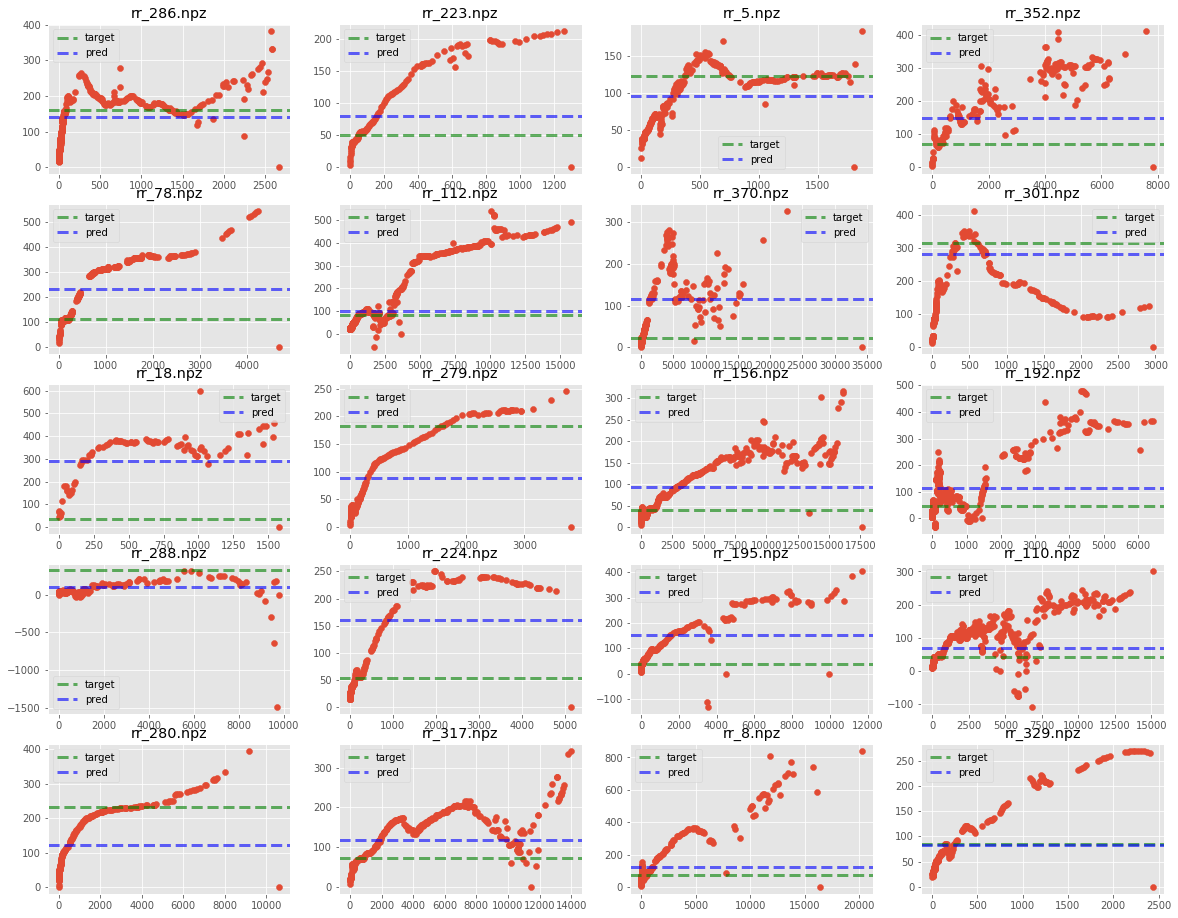

In [293]:
_, ax = plt.subplots(5, 4, figsize=(20, 16))
ax = ax.reshape(-1)
for i, name in enumerate(np.array(names)[z[40:60]]):
    d = dict(np.load('./npz/'+name))
    ax[i].scatter(d['time'], d['derivative'])
    ax[i].axhline(d['target'], ls='--', c='g', lw=3, alpha=0.6, label='target')
    ax[i].axhline(np.mean(results[name]['pred']), ls='--', c='b', lw=3, alpha=0.6, label='pred')
    ax[i].set_title('{}'.format(name))
    ax[i].legend()

# Примеры с наибольшей дисперсией

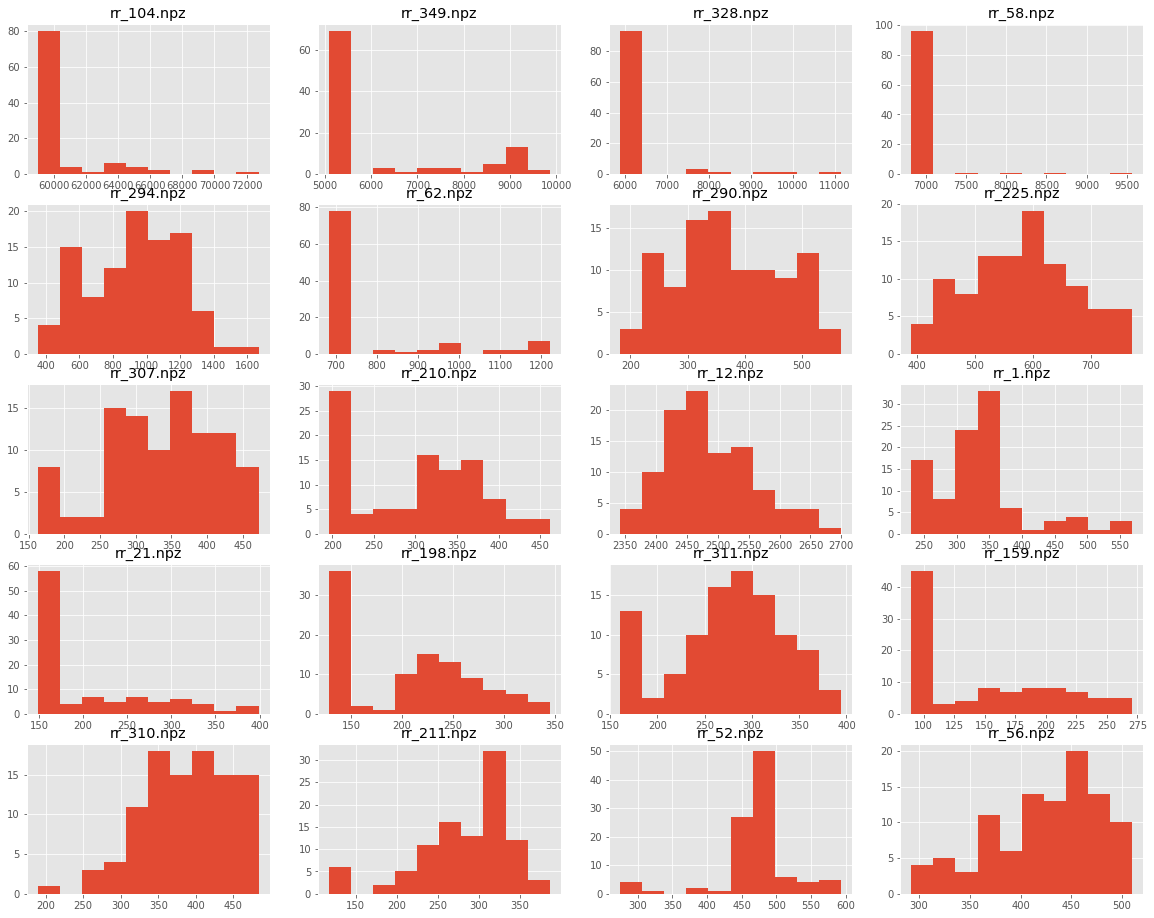

In [36]:
_, ax = plt.subplots(5, 4, figsize=(20, 16))
ax = ax.reshape(-1)
for i, ix in enumerate(z[:20]):
    ax[i].hist(results[names[ix]]['pred'])
    ax[i].set_title('{}'.format(names[ix]))
#     ax[i].axvline(np.mean(results[names[ix]]['pred']), ls='--', c='b', lw=3, alpha=0.6, label='target')
#     ax[i].axvline(results[names[ix]]['true'], ls='--', c='g', lw=3, alpha=0.6, label='target')

# Примеры с наименьшей разницей между средним предсказанием и реальным ответом

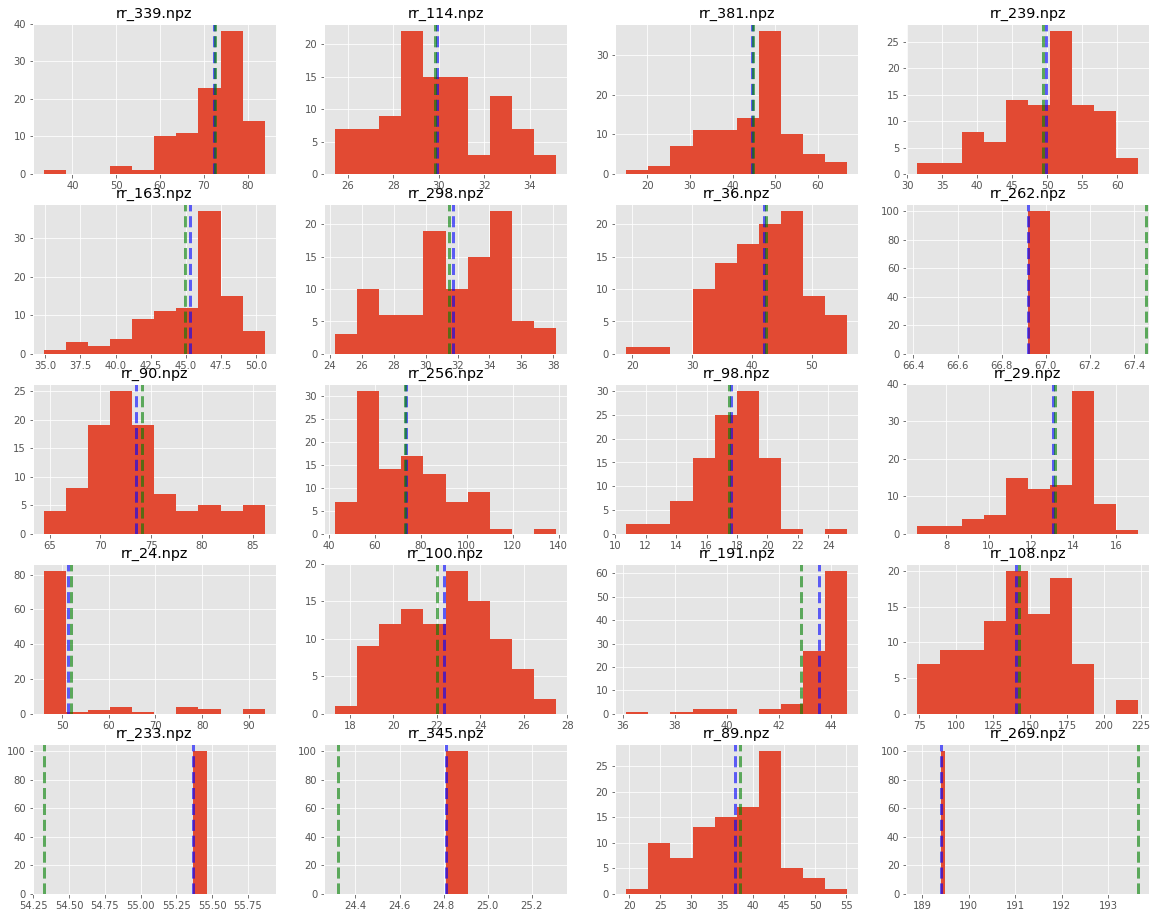

In [13]:
bad = np.argsort(mean)[::][:20]
_, ax = plt.subplots(5, 4, figsize=(20, 16))
ax = ax.reshape(-1)
names = list(results.keys())
for i, n in enumerate(bad):
    ax[i].hist(results[names[n]]['pred'])
    ax[i].axvline(np.mean(results[names[n]]['pred']), ls='--', c='b', lw=3, alpha=0.6, label='target')
    ax[i].axvline(results[names[n]]['true'], ls='--', c='g', lw=3, alpha=0.6, label='target')
    ax[i].set_title('{}'.format(names[n]))

Интересно, что зачастую предсказания модели имеют большую дисперсию, но в среднем дают хороший ответ.

In [91]:
point = np.concatenate(np.array(norm_te_ppl.get_variable('points')))#np.array(norm_te_ppl.get_variable('points')).reshape(-1, 2, N_SAMPLES)
target = np.array(norm_te_ppl.get_variable('targets'))
predictions = np.concatenate(norm_te_ppl.get_variable('predictions'))#np.array(norm_te_ppl.get_variable('predictions')).reshape(-1)
# print(np.quantile(np.abs(target-predictions)/target, q=0.3))
# plt.hist(np.abs(target-predictions)/target)
mae(target, predictions)

0.4570772271975961